<a href="https://colab.research.google.com/github/stephyi/Using_SparkSql_And_Pyspark_Analysis/blob/main/spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [1]:
#Installing the required dependencies

!apt-get install openjdk-8-jdk-headless 
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xvf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark


!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u275-b01-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u275-b01-0ubuntu1~18.04 [8,269 kB]
Fetched 36.5 MB in 2s (18.0 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database

In [2]:
#Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Query and Analysis using Spark SQL

In [3]:
#Tools we need to connect to the SparK Server 
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
#Load datasets
# Creating a dataframe form reading a csv file

df=spark.read.options(header="true",inferschema="true").csv('03-02-2018.csv')

In [5]:
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")

The shape is 46200 rows by 80 columns.


>> This is a massive amount of data!!

In [ ]:
## Let's look at some data points from our dataframe
#df=spark.read.options(header="true",inferschema="true").csv('03-02-2018.csv')
df.show(10)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [ ]:
## Printing the Dataframe Schema
df.printSchema()

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: decimal(9,0) (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: decimal(9,0) (nullable = true)
 |-- Flow IAT Min: decimal(9

In [ ]:
df.na.drop()
df=df.fillna(1)

#df.na.drop(Seq("c_name")).select(avg(col("c_name")))

##  Spark SQL

In [ ]:
# Typically the entry point into all SQL functionality in Spark is the SQLContext class. To create a basic instance of this call, all we need is a SparkContext reference
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc=SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
sqlContext

In [ ]:
#Register temporary table
df.registerTempTable('sample')
protocols_frequency = sqlContext.sql("""
                           SELECT Protocol, count(*) as freq
                           FROM sample
                           GROUP BY Protocol
                           """)
protocols_frequency.show()

+--------+------+
|Protocol|  freq|
+--------+------+
|       6|832490|
|      17|202699|
|       0| 13382|
+--------+------+



In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-

In [ ]:
 #Register temporary table
df.registerTempTable('sample')
timestamp_by_day_of_month = sqlContext.sql("""
                           SELECT Timestamp,
                           COALESCE(AVG("Tot Fwd Pkts"),0) as mean_Forward_packets,AVG("Tot Bwd Pkts") as mean_Backward_packets
                           FROM sample
                           GROUP BY Timestamp
                           """)
timestamp_by_day_of_month.show()

+-------------------+--------------------+---------------------+
|          Timestamp|mean_Forward_packets|mean_Backward_packets|
+-------------------+--------------------+---------------------+
|02/03/2018 09:04:22|                   1|                    1|
|02/03/2018 09:38:34|                   2|                    2|
|02/03/2018 09:49:10|                   2|                    2|
|02/03/2018 09:47:13|                   2|                    2|
|02/03/2018 10:18:28|                   2|                    2|
|02/03/2018 10:24:34|                   2|                    2|
|02/03/2018 10:31:42|                   2|                    2|
|02/03/2018 10:36:54|                   2|                    2|
|02/03/2018 10:47:00|                   9|                    9|
|02/03/2018 10:49:46|                   6|                    6|
|02/03/2018 10:56:39|                   4|                    4|
|02/03/2018 11:02:01|                   2|                    2|
|02/03/2018 11:04:28|    

In [ ]:
#Register temporary table
df1.registerTempTable('sample')
protocols = sqlContext.sql("""
                           SELECT Label,Protocol, count(*) as freq
                           FROM sample
                           GROUP BY Protocol,Label
                           """)
protocols.show(10)

+------+--------+------+
| Label|Protocol|  freq|
+------+--------+------+
|   Bot|       0|   258|
|Benign|      17| 91256|
|   Bot|       6|285933|
|Benign|       0|  6999|
|Benign|       6|241282|
+------+--------+------+



In [ ]:
attack_stats = sqlContext.sql("""
                           SELECT *,
                             CASE Label
                               WHEN 'Benign' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG("Fwd Byts/b Avg"), 2) as mean_fwd_bytes,
                             ROUND(AVG("Flow Duration"), 2) as mean_duration,
                             AVG("Pkt Size Avg") as pkt_size_avg,
                           FROM connections
                           GROUP BY Label, state
                           ORDER BY 3 DESC
                           """)
display(attack_stats)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [ ]:
#Register temporary table
df.registerTempTable('sample')
flow_duration_by_port = sqlContext.sql("""
                           SELECT Protocol,`Dst Port`, count("Tot Fwd Pkts") as tot_fwd_packets
                           FROM sample
                           GROUP By `Dst Port`,Protocol
                           ORDER BY tot_fwd_packets DESC
                           LIMIT 25
                           """)
flow_duration_by_port.show()

+--------+--------+---------------+
|Protocol|Dst Port|tot_fwd_packets|
+--------+--------+---------------+
|       6|    8080|         281637|
|      17|      53|         192896|
|       6|    3389|         175693|
|       6|      80|         110411|
|       6|     443|          94825|
|       6|     445|          41706|
|       0|       0|          13382|
|      17|    5355|           4578|
|      17|    3389|           1754|
|      17|     137|           1641|
|      17|      67|            707|
|      17|     123|            461|
|      17|     138|            442|
|       6|      22|            324|
|       6|      23|            128|
|      17|   40468|             60|
|      17|    1900|             58|
|       6|     139|             43|
|       6|   50220|             41|
|       6|   49992|             40|
+--------+--------+---------------+
only showing top 20 rows



In [ ]:
#Register temporary table
df.registerTempTable('sample')
flow_duration_by_port = sqlContext.sql("""
                           SELECT `Dst Port`,count("Flow Duration") as flow_duration
                           FROM sample
                           GROUP By `Dst Port`
                           ORDER BY flow_duration DESC
                           LIMIT 25
                           """)
flow_duration_by_port.show()

+--------+-------------+
|Dst Port|flow_duration|
+--------+-------------+
|    8080|       281637|
|      53|       192903|
|    3389|       177447|
|      80|       110411|
|     443|        94825|
|     445|        41706|
|       0|        13382|
|    5355|         4579|
|     137|         1641|
|      67|          707|
|     123|          461|
|     138|          442|
|      22|          324|
|      23|          128|
|   40468|           61|
|    1900|           59|
|     139|           43|
|   50220|           41|
|   49992|           40|
|   49977|           40|
+--------+-------------+
only showing top 20 rows



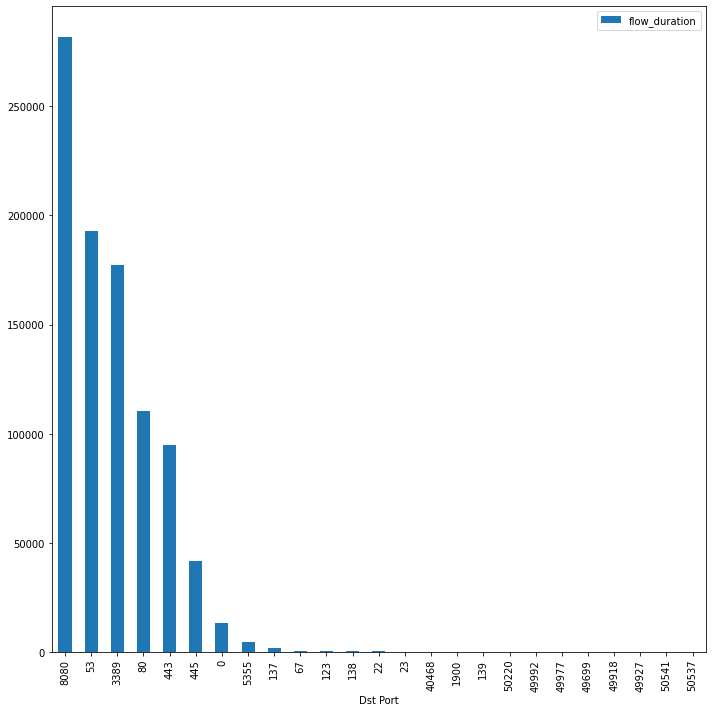

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

flow_duration_by_port_df = pd.DataFrame(flow_duration_by_port.toPandas())
flow_duration_by_port_df.set_index("Dst Port", drop=True,inplace=True)
labels_fig = flow_duration_by_port_df.plot(kind='bar')

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
#display(labels_fig.figure)

In [ ]:


#Register temporary table
df.registerTempTable('sample')
labels = sqlContext.sql("""
                           SELECT Label ,count(*) as freq
                           FROM sample
                           GROUP By Label
                           """)
labels.show()

+------+-----+
| Label| freq|
+------+-----+
|Benign| 9520|
|   Bot|36680|
+------+-----+



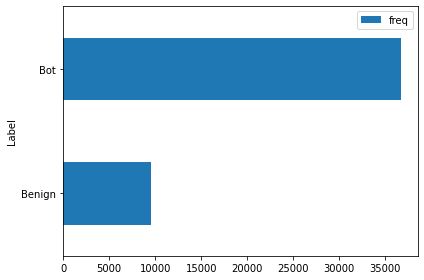

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

labels_df = pd.DataFrame(labels.toPandas())
labels_df.set_index("Label", drop=True,inplace=True)
labels_fig = labels_df.plot(kind='barh')

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
#display(labels_fig.figure)

# Analyze and interpret Big Data using Pyspark

## Using pyspark

In [ ]:
# Let's have a look at some columns
df.select("Label").distinct().show(10)

+------+
| Label|
+------+
|Benign|
|   Bot|
+------+



In [ ]:
df.groupBy("Dst Port").count().filter("count >5").orderBy("count").show(10)

+--------+-----+
|Dst Port|count|
+--------+-----+
|   53597|    6|
|   53294|    6|
|   55577|    6|
|   58431|    6|
|   53110|    6|
|   53658|    6|
|   56350|    6|
|   53168|    6|
|   57150|    6|
|   61785|    6|
+--------+-----+
only showing top 10 rows



In [ ]:
df.groupBy("Protocol").count().filter("count >5").orderBy("count").show(10)

+--------+-----+
|Protocol|count|
+--------+-----+
|       0|  403|
|      17| 1706|
|       6|44091|
+--------+-----+



In [ ]:
df.select("Protocol").distinct().show()

+--------+
|Protocol|
+--------+
|       6|
|      17|
|       0|
+--------+



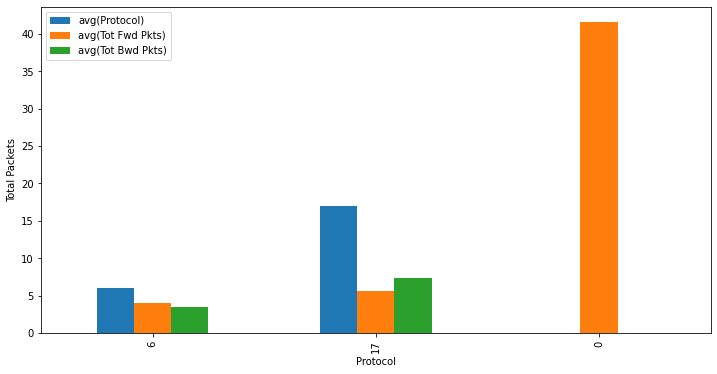

In [ ]:
import matplotlib.pyplot as plt

sec_df =  df.select(['Protocol', 
                       'Tot Fwd Pkts', 
                       'Tot Bwd Pkts']
                     )\
                     .groupBy('Protocol')\
                     .mean()\
                     .toPandas()


sec_df.plot(kind = 'bar', x='Protocol', y = sec_df.columns.tolist()[1:], 
                         figsize=(12, 6), ylabel = 'Total Packets', xlabel = 'Protocol')
plt.show()

In [ ]:
import pyspark.sql.functions as f


#Extracting the day of month 
df1 = df.withColumn('Timestamp',f.dayofmonth(f.to_timestamp('Timestamp', 'dd/MM/yyyy')))
df1.show(10)

+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------

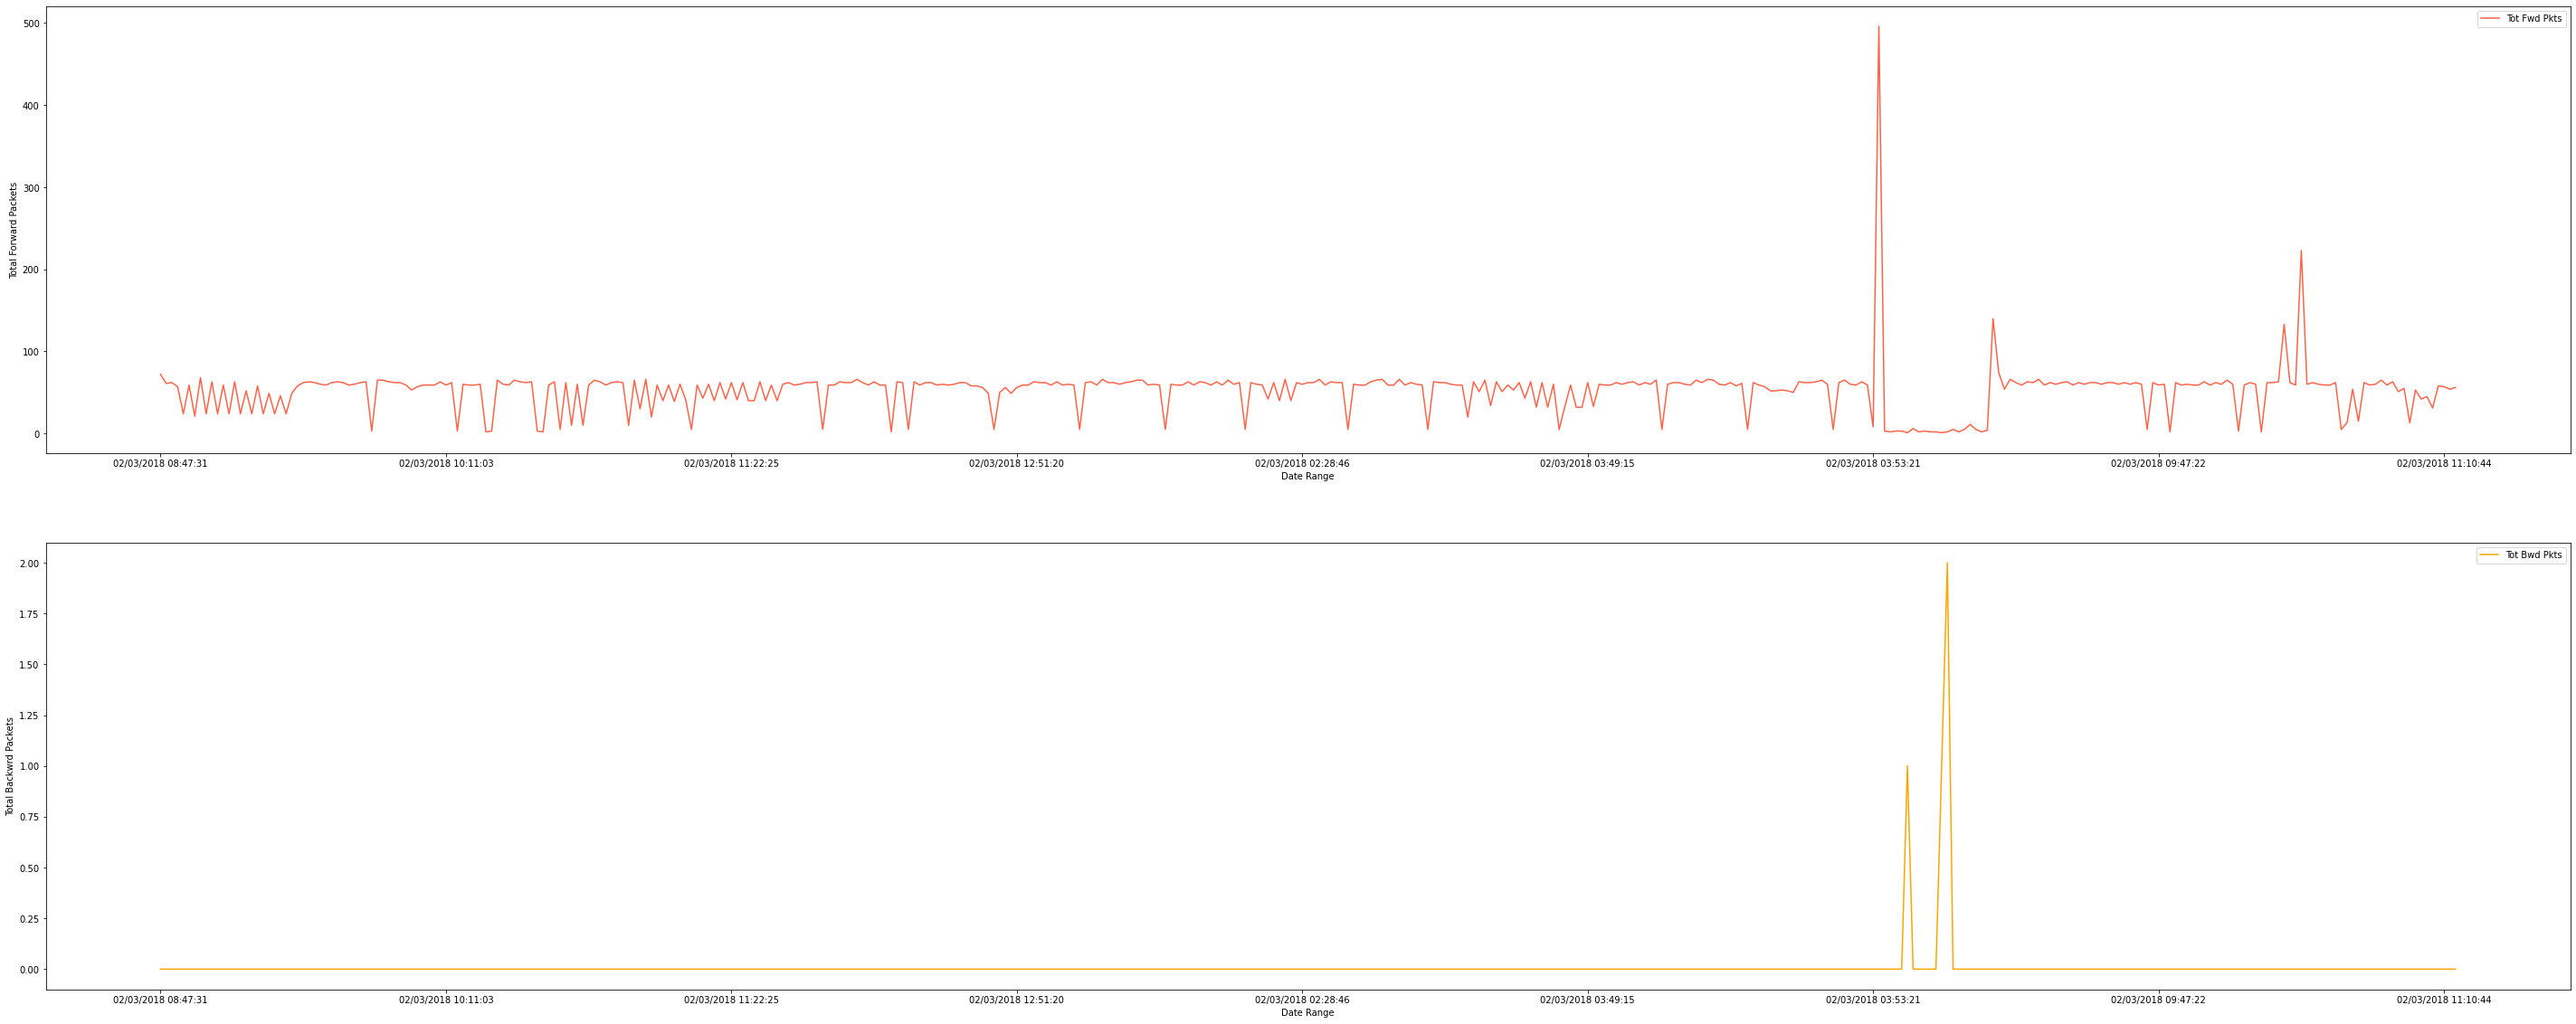

In [ ]:
from pyspark.sql.functions import col

tech = df.where(col('Protocol') == 0)\
           .select('Timestamp','Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize =(50, 20))

#tech.toPandas().plot(kind = 'line', x = 'Timestamp', y='Flow Duration', 
                     #xlabel = 'Date Range', ylabel = 'Flow Duration', 
                     #ax = axes[0], color = 'mediumspringgreen')

tech.toPandas().plot(kind = 'line', x = 'Timestamp', y='Tot Fwd Pkts',
                     xlabel = 'Date Range', ylabel = 'Total Forward Packets',
                     ax = axes[0], color = 'tomato')

tech.toPandas().plot(kind = 'line', x = 'Timestamp', y='Tot Bwd Pkts', 
                     xlabel = 'Date Range', ylabel = 'Total Backwrd Packets', 
                     ax = axes[1], color = 'orange')

plt.show()

## Descriptive Analytics

In [7]:
import pyspark.sql.functions as f


#Extracting the day of month 
df = df.withColumn('Timestamp',f.dayofmonth(f.to_timestamp('Timestamp', 'dd/MM/yyyy')))
df.show(10)

num_cols=df.drop('Label').columns

+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------

In [ ]:
df.describe().show()

+-------+------------------+----------------+---------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------+-----------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+--------------------+--------------------+-----------------+------------------+-----------------+------------------+--------------------+-------------+-------------+-------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+--------------+-------------------+--------

##### To get a brief description of each column ,we use the describe function.

In [ ]:
 import numpy as np
 def describe_pd(df_in, columns, deciles=False):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [ ]:
describe_pd(df,num_cols,deciles=True)

TypeError: ignored

In [ ]:
#Kurtosis and skewness for each column


from pyspark.sql.functions import col, skewness, kurtosis

for col in num_cols:
  df.select(skewness(col),kurtosis(col)).show()

+------------------+------------------+
|skewness(Dst Port)|kurtosis(Dst Port)|
+------------------+------------------+
|2.8275304453316163| 7.121988886627928|
+------------------+------------------+

+------------------+------------------+
|skewness(Protocol)|kurtosis(Protocol)|
+------------------+------------------+
|1.8577989150730132|1.9142154579640875|
+------------------+------------------+

+-------------------+-------------------+
|skewness(Timestamp)|kurtosis(Timestamp)|
+-------------------+-------------------+
|                NaN|                NaN|
+-------------------+-------------------+

+-----------------------+-----------------------+
|skewness(Flow Duration)|kurtosis(Flow Duration)|
+-----------------------+-----------------------+
|      3.206555781706071|      8.882578517875729|
+-----------------------+-----------------------+

+----------------------+----------------------+
|skewness(Tot Fwd Pkts)|kurtosis(Tot Fwd Pkts)|
+----------------------+----------------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

var = "Flow Duration"
x = df.select(var).toPandas()
bins = np.arange(0, 100, 5.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar',ec='black')

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Box Plot
var="Tot Fwd Packets"
x = df.select(var).toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Box Plot
var="Tot Bwd Packets"
x = df.select(var).toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x)

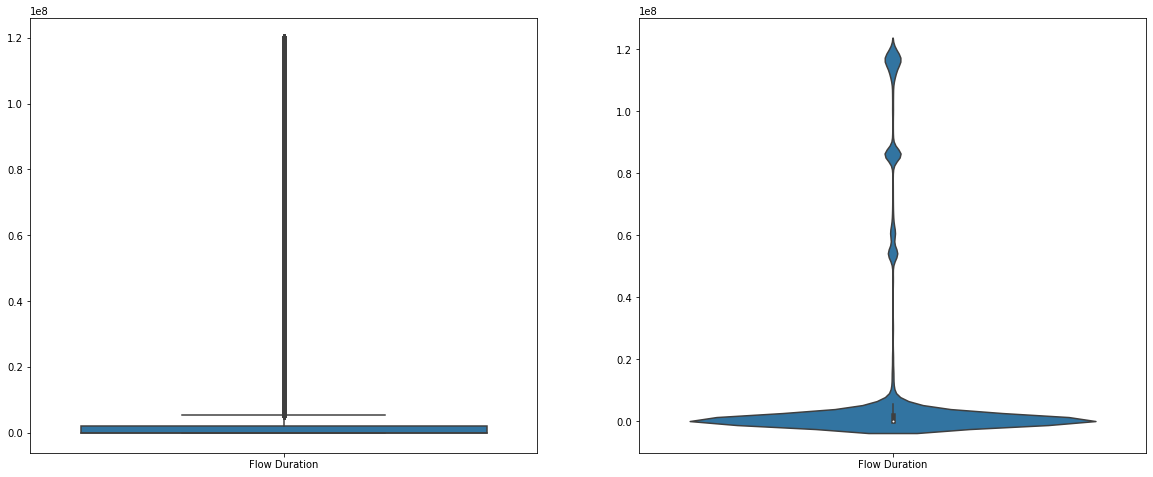

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Box Plot
var="Flow Duration"
x = df.select(var).toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x)

In [ ]:
# Data to plot
labels = df.Label
sizes =  plot_data.Percent
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0, 0.1, 0, 0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

df=df.sample(0.20)

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
# withColumn('Percent %',F.format_string("%5.0f%%\n",col('Credit_num')*100/col('total'))).\
tab = df.select(['Protocol','Flow Duration']).\
   groupBy('Protocol').\
   agg(F.count('Flow Duration').alias('Flow Duration'),
       F.mean('Flow Duration').alias('Flow Duration_avg'),
       F.min('Flow Duration').alias('Flow Duration_min'),
       F.max('Flow Duration').alias('Flow Duration_max')).\
   withColumn('total',sum(col('Flow Duration')).over(window)).\
   withColumn('Percent',col('Flow Duration')*100/col('total')).\
   drop(col('total'))

In [ ]:
tab.show()

+--------+-------------+--------------------+-----------------+-----------------+------------------+
|Protocol|Flow Duration|   Flow Duration_avg|Flow Duration_min|Flow Duration_max|           Percent|
+--------+-------------+--------------------+-----------------+-----------------+------------------+
|       6|       166322|1.2785620778501943E7|                0|        119999997| 79.45255212936203|
|      17|        40308|  1261140.0898332838|               63|        119999432| 19.25526070652304|
|       0|         2705|  8.70480319064695E7|               44|        119997167|1.2921871641149354|
+--------+-------------+--------------------+-----------------+-----------------+------------------+



### Correlation Matrix

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 2.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])


ValueError: ignored

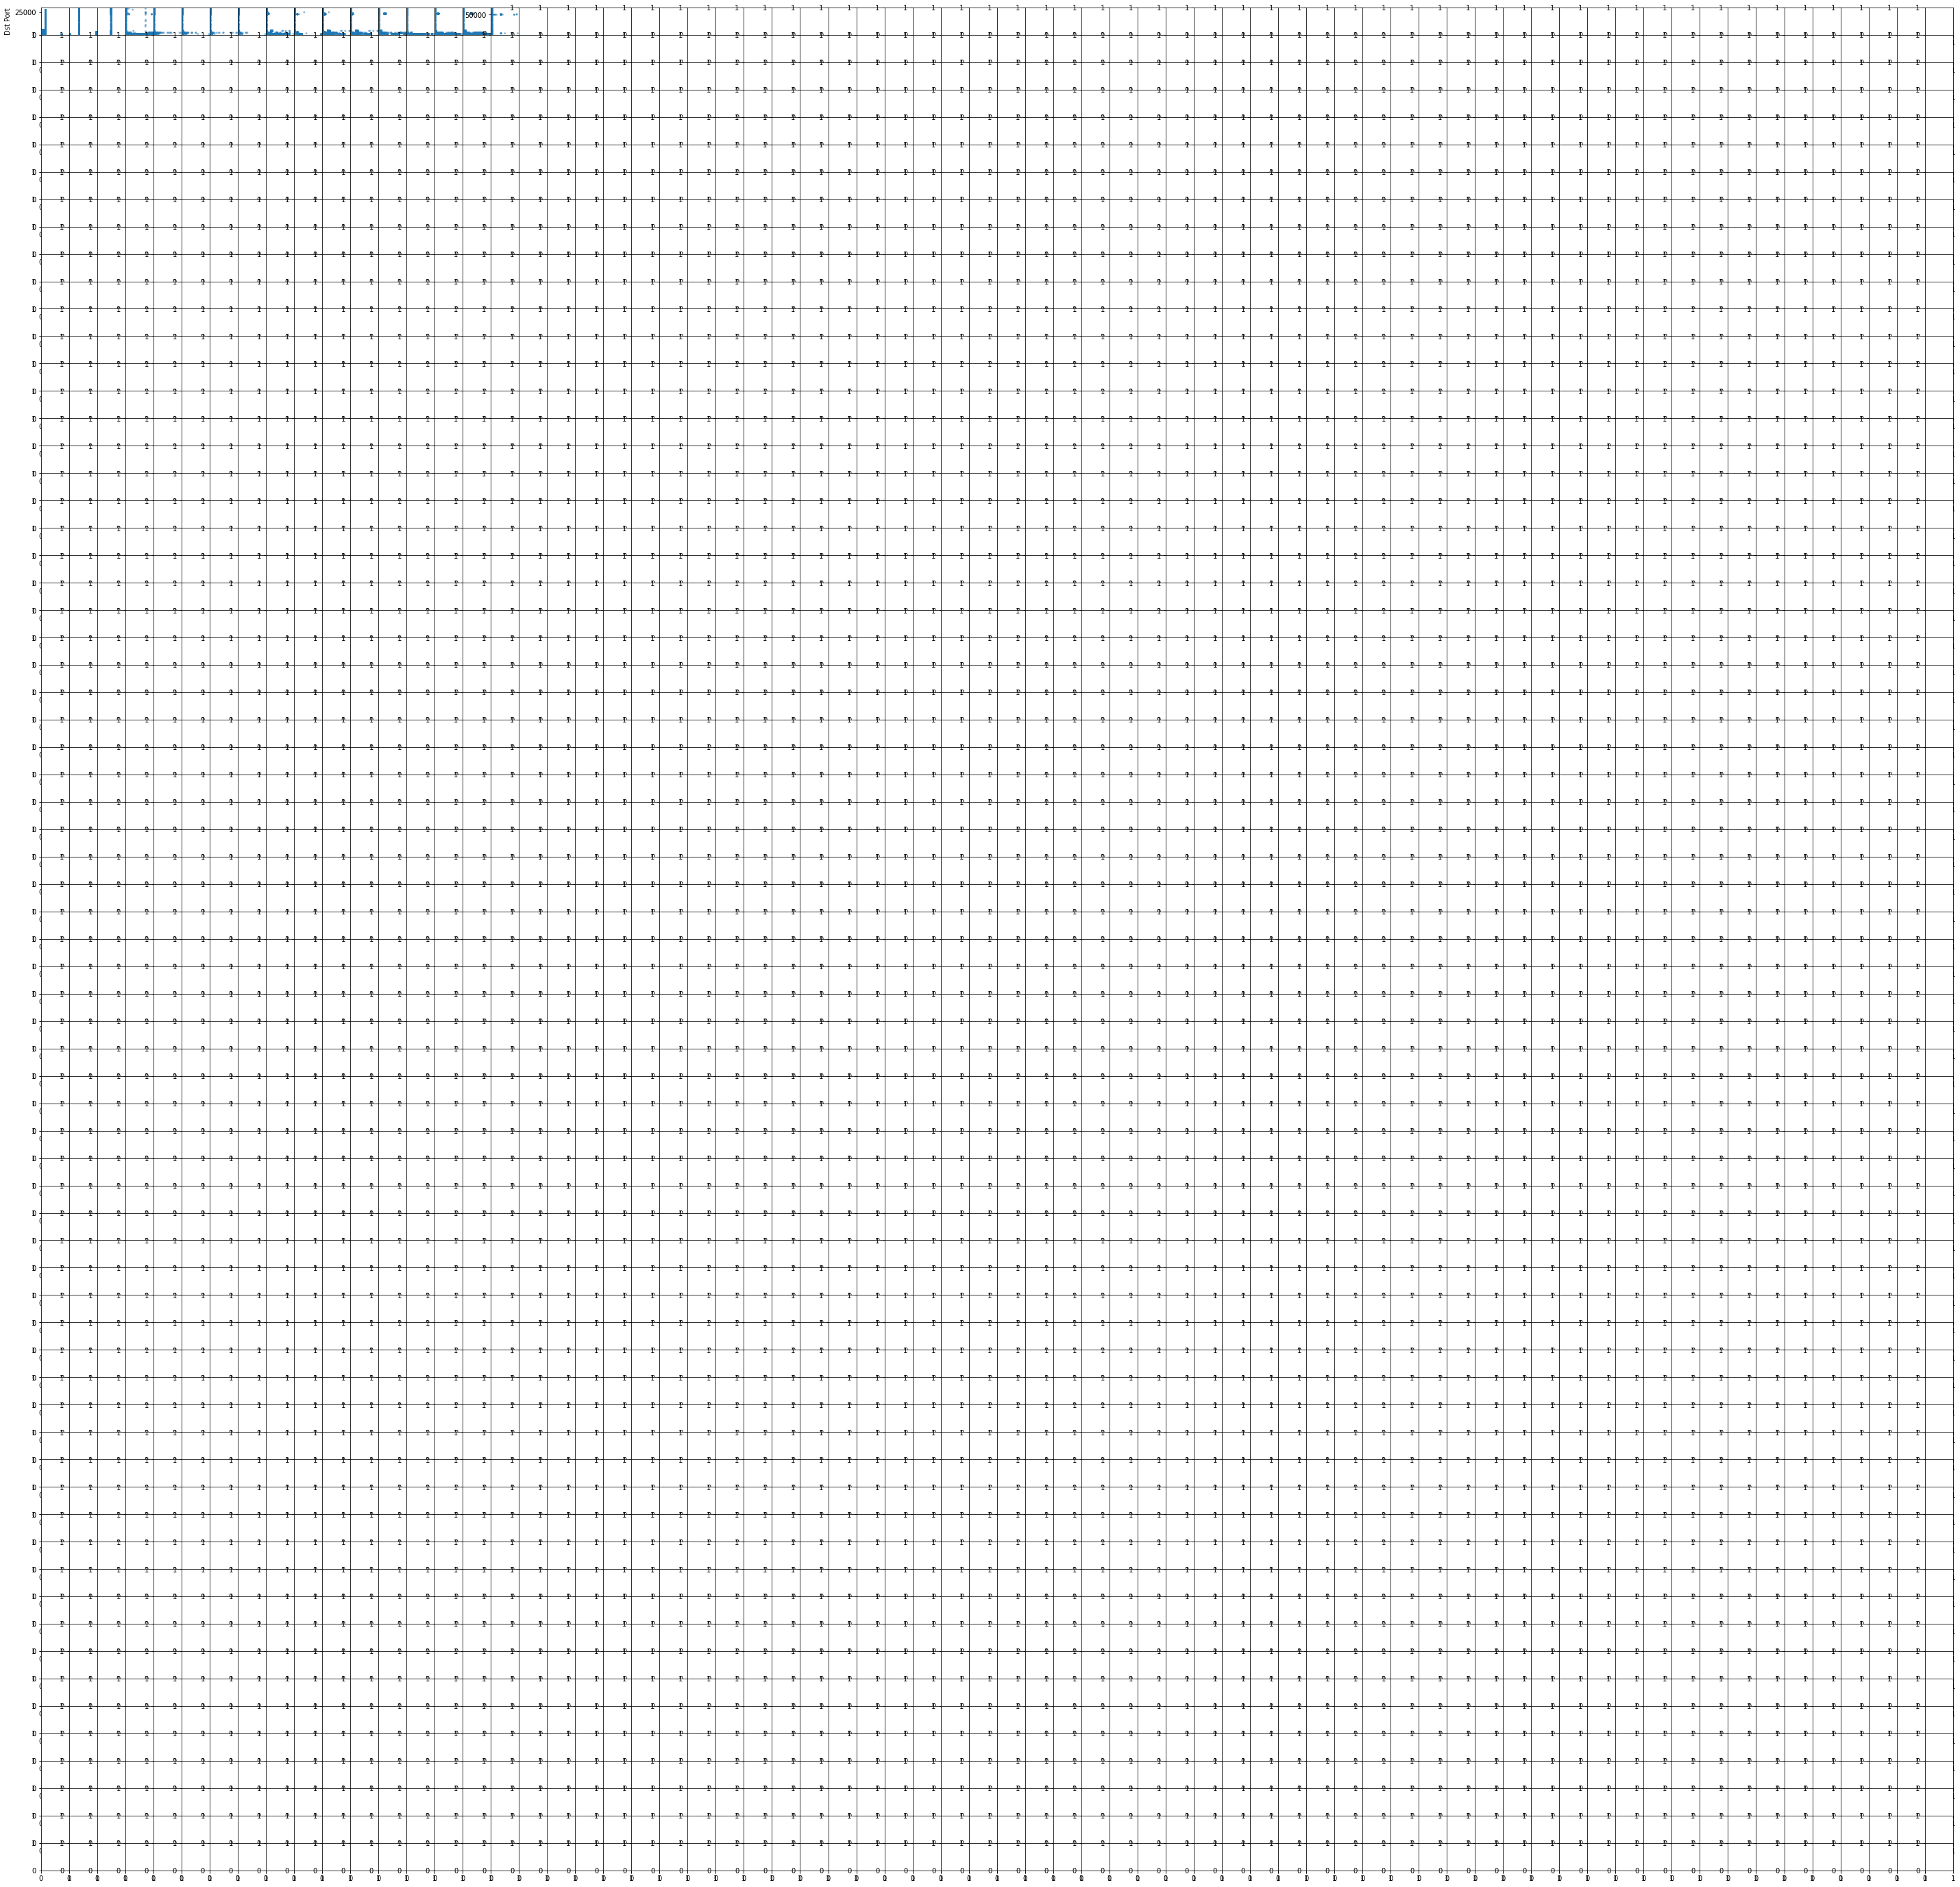

In [17]:

from pandas.plotting import scatter_matrix
import pandas as pd


numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(50, 50))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [15]:
import six
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Label for ", i, df.stat.corr('LabelIndex',i))

Correlation to MV for  Dst Port -0.057519205369691344
Correlation to MV for  Protocol 0.32766492952291687
Correlation to MV for  Timestamp nan
Correlation to MV for  Flow Duration 0.3582927233917063
Correlation to MV for  Tot Fwd Pkts 0.19725778903639474
Correlation to MV for  Tot Bwd Pkts 0.1442792331750412
Correlation to MV for  TotLen Fwd Pkts 0.14419095903897955
Correlation to MV for  TotLen Bwd Pkts 0.0550412399219716
Correlation to MV for  Fwd Pkt Len Max 0.2150394034649986
Correlation to MV for  Fwd Pkt Len Min 0.299938919266105
Correlation to MV for  Fwd Pkt Len Mean 0.09946693899670661
Correlation to MV for  Fwd Pkt Len Std -0.0039055946752515947
Correlation to MV for  Bwd Pkt Len Max 0.5467278320909231
Correlation to MV for  Bwd Pkt Len Min 0.3402392716883845
Correlation to MV for  Bwd Pkt Len Mean 0.4934484812278822
Correlation to MV for  Bwd Pkt Len Std 0.481764052880998
Correlation to MV for  Flow Byts/s nan
Correlation to MV for  Flow Pkts/s nan
Correlation to MV for  Flo

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median value tends to go up when the number of rooms goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; the median value tends to go down when the percentage of the lower status of the population goes up. Finally, coefficients close to zero mean that there is no linear correlation.

In [19]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Protocol','Flow Duration','Bwd Pkt Len Max','Bwd Pkt Len Std','Bwd Pkt Len Mean','Pkt Size Avg','Bwd Seg Size Avg','Init Bwd Win Byts'], outputCol = 'features')
vdf = vectorAssembler.transform(df)
vdf = vdf.select(['features', 'LabelIndex'])
vdf.show(3)

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|[6.0,141385.0,146...|       1.0|
|(8,[0,1,5],[6.0,2...|       1.0|
|[6.0,279824.0,146...|       1.0|
+--------------------+----------+
only showing top 3 rows



In [20]:
splits = vdf.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [23]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'LabelIndex')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="LabelIndex", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0595708


In [24]:
dt_model.featureImportances

SparseVector(8, {0: 0.1453, 1: 0.7986, 2: 0.0151, 3: 0.0167, 4: 0.0, 5: 0.0231, 7: 0.0012})

In [25]:
df.take(1)

[Row(Dst Port=443, Protocol=6, Timestamp=2, Flow Duration=141385, Tot Fwd Pkts=9, Tot Bwd Pkts=7, TotLen Fwd Pkts=553, TotLen Bwd Pkts=3773, Fwd Pkt Len Max=202, Fwd Pkt Len Min=0, Fwd Pkt Len Mean=61.44444444, Fwd Pkt Len Std=87.53443767, Bwd Pkt Len Max=1460, Bwd Pkt Len Min=0, Bwd Pkt Len Mean=539.0, Bwd Pkt Len Std=655.4329358, Flow Byts/s=30597.30523, Flow Pkts/s=113.1661775, Flow IAT Mean=9425.666667, Flow IAT Std=19069.11685, Flow IAT Max=Decimal('73403'), Flow IAT Min=Decimal('1'), Fwd IAT Tot=Decimal('141385'), Fwd IAT Mean=17673.125, Fwd IAT Std=23965.32327, Fwd IAT Max=Decimal('73403'), Fwd IAT Min=Decimal('22'), Bwd IAT Tot=Decimal('51417'), Bwd IAT Mean=8569.5, Bwd IAT Std=13036.89082, Bwd IAT Max=Decimal('31525'), Bwd IAT Min=Decimal('1'), Fwd PSH Flags=0, Bwd PSH Flags=0, Fwd URG Flags=0, Bwd URG Flags=0, Fwd Header Len=192, Bwd Header Len=152, Fwd Pkts/s=63.65597482, Bwd Pkts/s=49.51020264, Pkt Len Min=0, Pkt Len Max=1460, Pkt Len Mean=254.4705882, Pkt Len Std=474.71295

In [16]:
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_data = df.select(num_cols)

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

                   Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  Fwd Pkt Len Std  Bwd Pkt Len Max  Bwd Pkt Len Min  Bwd Pkt Len Mean  Bwd Pkt Len Std  Flow Byts/s  Flow Pkts/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Tot  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Tot  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  Fwd Header Len  Bwd Header Len  Fwd Pkts/s  Bwd Pkts/s  Pkt Len Min  Pkt Len Max  Pkt Len Mean  Pkt Len Std  Pkt Len Var  FIN Flag Cnt  SYN Flag Cnt  RST Flag Cnt  PSH Flag Cnt  ACK Flag Cnt  URG Flag Cnt  CWE Flag Count  ECE Flag Cnt  Down/Up Ratio  Pkt Size Avg  Fwd Seg Size Avg  Bwd Seg Size Avg  Fwd Byts/b Avg  Fwd Pkts/b Avg  Fwd Blk Rate Avg  Bwd Byts/b Avg  Bwd Pkts/b Avg  Bwd Blk Rate Avg  Subflow Fwd Pkts  Subflow Fwd Byts  Subflow Bwd Pkts  Subfl


# Linear Regression Model


Linear Regression model is one the oldest and widely used machine learning approach which assumes a relationship between dependent and independent variables. For example, we might want to model the flow duration.

Now that we have uploaded the dataset, we can start analyzing. 
For our linear regression model we need to import two modules from Pyspark i.e. Vector Assembler and Linear Regression. Vector Assembler is a transformer that assembles all the features into one vector from multiple columns that contain type double. We could have used StringIndexer if any of our columns contains string values to convert it into numeric values. 

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import IndexToString, StringIndexer


Notice that we used InferSchema inside read.csv mofule. InferSchema enables us to infer automatically different data types for each column.

Let us print look into the dataset to see the data types of each column:

In [ ]:
df.printSchema()

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: decimal(9,0) (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: decimal(9,0) (nullable = true)
 |-- Flow IAT Min: decimal(

Next step is to convert all the features from different columns into a single column and let's call this new vector column as 'Attributes' in the outputCol.

In [14]:
#
indexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")
indexed = indexer.fit(df).transform(df)
indexed.show()

df=indexed.drop('Label')
df.show(10)



+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------

In [ ]:
# From above the whole data is for year 2018
df2.select("Timestamp").distinct().show()

+---------+
|Timestamp|
+---------+
|     2018|
+---------+



In [26]:
#Extracting the day of month 

from pyspark.sql import functions as f
df_model = df.withColumn('Timestamp',f.dayofmonth(f.to_timestamp('Timestamp', 'dd/MM/yyyy')))
df_model.show(10)

AnalysisException: ignored

In [27]:
## Dealing with null values

#na func to drop rows with null values
#rows having atleast a null value is dropped
df.na.drop()
df=df.na.fill(1)

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df_model.select([count(when(isnan(c), c)).alias(c) for c in df_model.columns]).show()

+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-

In [28]:
#Input all the features in one vector column
assembler = VectorAssembler(inputCols=df.columns, outputCol = 'Attributes')

output = assembler.setHandleInvalid("skip").transform(df)



#Input vs Output
finalized_data = output.select("Attributes","Flow Duration")

finalized_data.show()

+--------------------+-------------+
|          Attributes|Flow Duration|
+--------------------+-------------+
|[443.0,6.0,2.0,14...|       141385|
|(80,[0,1,2,3,4,5,...|          281|
|[443.0,6.0,2.0,27...|       279824|
|(80,[0,1,2,3,4,17...|          132|
|[443.0,6.0,2.0,27...|       274016|
|(80,[0,1,2,3,4,17...|          250|
|(80,[0,1,2,3,4,5,...|      5964033|
|(80,[0,1,2,3,4,17...|          144|
|[443.0,6.0,2.0,90...|        90828|
|(80,[0,1,2,3,4,6,...|          152|
|(80,[0,1,2,3,4,5,...|       234228|
|[443.0,6.0,2.0,6....|     60860062|
|(80,[0,1,2,3,4,17...|        68899|
|(80,[2,3,4,17,18,...|    119250445|
|[443.0,6.0,2.0,1....|    116185749|
|[443.0,6.0,2.0,6....|     60602600|
|[80.0,6.0,2.0,1.1...|    116690356|
|[80.0,6.0,2.0,1.1...|    119731397|
|[443.0,6.0,2.0,1....|    118281864|
|(80,[0,1,2,3,4,6,...|          192|
+--------------------+-------------+
only showing top 20 rows



In [30]:
features=tuple(df.drop('Flow Duration').columns)
assembler = VectorAssembler(inputCols=features,outputCol="features")
 
raw_data=assembler.transform(df)
raw_data.select("features").show(truncate=True)

+--------------------+
|            features|
+--------------------+
|[443.0,6.0,2.0,9....|
|(79,[0,1,2,3,4,5,...|
|[443.0,6.0,2.0,11...|
|(79,[0,1,2,3,16,1...|
|[443.0,6.0,2.0,9....|
|(79,[0,1,2,3,16,1...|
|(79,[0,1,2,3,4,16...|
|(79,[0,1,2,3,16,1...|
|[443.0,6.0,2.0,8....|
|(79,[0,1,2,3,5,7,...|
|(79,[0,1,2,3,4,16...|
|[443.0,6.0,2.0,15...|
|(79,[0,1,2,3,16,1...|
|(79,[2,3,16,17,18...|
|[443.0,6.0,2.0,21...|
|[443.0,6.0,2.0,13...|
|[80.0,6.0,2.0,17....|
|[80.0,6.0,2.0,17....|
|[443.0,6.0,2.0,36...|
|(79,[0,1,2,3,5,7,...|
+--------------------+
only showing top 20 rows



In [31]:
from pyspark.ml.feature import StandardScaler

standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
raw_data=standardscaler.fit(raw_data).transform(raw_data)
raw_data.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[443.0,6.0,2.0,9....|[0.04412987701118...|
|(79,[0,1,2,3,4,5,...|(79,[0,1,2,3,4,5,...|
|[443.0,6.0,2.0,11...|[0.04412987701118...|
|(79,[0,1,2,3,16,1...|(79,[0,1,2,3,16,1...|
|[443.0,6.0,2.0,9....|[0.04412987701118...|
+--------------------+--------------------+
only showing top 5 rows



Here, 'Attributes' are in the input features from all the columns and 'Flow Duration' is the target column.
Next, we should split the training and testing data according to our dataset (0.8 and 0.2 in this case).

In [34]:
#Split training and testing data
train_data,test_data = raw_data.randomSplit([0.8,0.2])


regressor = LinearRegression(featuresCol = 'Scaled_features', labelCol = 'Flow Duration')

#Learn to fit the model from training set
regressor = regressor.fit(train_data)

#To predict the prices on testing set
pred = regressor.evaluate(test_data)

#Predict the model
pred.predictions.show()

IllegalArgumentException: ignored

We can also print the coefficient and intercept of the regression model by using the following command:

In [ ]:
#coefficient of the regression model
coeff = regressor.coefficients

#X and Y intercept
intr = regressor.intercept

print ("The coefficient of the model is : %a" %coeff)
print ("The Intercept of the model is : %f" %intr)


The coefficient of the model is : DenseVector([-0.1239, 0.056, 0.0205, 2.7283, -16.8634, 3.218, 0.0163, -1.4331, 0.3657, -0.0134, -0.9328, 0.0096, -0.6229])
The Intercept of the model is : 39.049826


# Classification Model

In [ ]:
df.show(10)

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [ ]:
#Extracting the day of month 
df1 = df.withColumn('Timestamp',f.dayofmonth(f.to_timestamp('Timestamp', 'dd/MM/yyyy')))
df1.show(10)

+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------

In [ ]:
df1.printSchema()

root
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: integer (nullable = true)
 |-- TotLen Bwd Pkts: decimal(9,0) (nullable = true)
 |-- Fwd Pkt Len Max: integer (nullable = true)
 |-- Fwd Pkt Len Min: integer (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: integer (nullable = true)
 |-- Bwd Pkt Len Min: integer (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: decimal(9,0) (nullable = true)
 |-- Flow IAT Min: decimal(

In [ ]:
df3=df3.withColumn("Fwd Blk Rate Avg", df3("Fwd Blk Rate Avg").cast(DoubleType))

TypeError: ignored

In [ ]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['Label']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Label', outputCol = 'labels')
stages += [label_stringIdx]
numericCols = df1.drop("labels").columns
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

The above code are taken from databricks’ official site and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df1)
df1 = pipelineModel.transform(df1)

cols=df1.columns
selectedCols = ['labels', 'features'] + cols
df1 = df1.select(selectedCols)
df1.printSchema()

IllegalArgumentException: ignored

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Clustering Model

In [ ]:
from pyspark.ml.feature import VectorAssembler

features =  df3.columns 
      
 

assembler = VectorAssembler(inputCols=features,outputCol="features")

dataset=assembler.transform(df3)
dataset.select("features").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
#%spark.pyspark

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

#silhouette = evaluator.evaluate(predictions)
#print("Silhouette with squared euclidean distance = " + str(silhouette))


# Evaluate clustering.
cost = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Within Set Sum of Squared Errors = inf
Cluster Centers: 
[8.08084082e+03 6.44794288e+00 2.00000000e+00 3.31691055e+06
 4.32202043e+00 3.61182976e+00 2.62154513e+02 6.32624509e+02
 1.89344927e+02 1.89444077e+00 5.74955827e+01 9.44752065e+01
 1.55011864e+02 4.52999296e+00 4.05992095e+01 6.10535038e+01
            inf            inf 2.59521690e+05 1.86327432e+05
 7.94466458e+05 1.62271424e+05 3.27169134e+06 3.49299035e+05
 1.88949604e+05 7.90131252e+05 2.16708889e+05 2.36506371e+06
 1.82136160e+05 1.58246288e+05 4.97146219e+05 6.45750272e+04
 1.23171096e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.38286056e+01 7.55575438e+01 5.27495247e+03 6.66994381e+02
 1.87593311e+00 2.41451190e+02 4.20948189e+01 7.76274297e+01
 1.54103179e+04 6.55846095e-04 1.23171096e-02 4.62664761e-01
 5.08771275e-01 4.36622872e-01 5.09213838e-03 0.00000000e+00
 4.62664761e-01 4.98539010e-01 4.76285438e+01 5.74955827e+01
 4.05992095e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+

This code below is taken directly from the Spark ML documentation with some modifications, because there’s only one way to use the algorithm. A couple items to note:

KMeans().setK(2).setSeed(1)⁠—The number 2 is the number of clusters to divide the data into. We see that any number larger than 2 causes this value ClusteringEvaluator() to fall below 0.5, meaning it’s not a clear division. Another way to check the optimal number of clusters would be to plot an elbow curve.
predictions = model.transform(dataset)—This will add the prediction column to the dataframe, so we can show which patients qualify for which category.
The rest of the code is self-evident. The code prints the cluster centers for each division as well as the sum of squared errors. That’s a clue to how it works: it computes the distance of each data point from its guess as to the center of the cluster, adjusts the guesses, then repeats until the number reaches its minimum. The distance of each point from this central point is squared so that distance is always positive. The goal is to have the smallest number possible—the shortest distance between all the data points.

Below, the algorithm shows the squared Euclidean distance.

If this number is negative, the data cannot be separated at all.
Values closer to 1 indicate maximum separation.
Values close to zero mean the data could barely be separated.
In this example, 0.81 is not bad.

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


# Evaluate clustering.
cost = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)